# Displacement time series

Note: this is an experimental demonstration notebook. For more advanced time series generation check out libraries like https://github.com/insarlab/MintPy. The goal here is to generate a fast and simple first-pass estimate.

(Ascending track 64)

In [1]:
import hyp3_sdk as sdk
import xarray as xr
import geopandas as gpd
import pandas as pd
import odc.stac
import pystac
import concurrent.futures
from utils import hyp32stac
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Look up fileURLs from HYP3 SDK
hyp3 = sdk.HyP3() 
myjobs = hyp3.find_jobs(job_type='INSAR_ISCE_BURST')
df = pd.DataFrame([x.to_dict() for x in myjobs])

In [4]:
df.status_code.value_counts()

status_code
SUCCEEDED    483
FAILED         1
Name: count, dtype: int64

In [5]:
df['refdate'] = pd.to_datetime(df['name'].str[15:23], format='%Y%m%d', errors='coerce')
df = df[df['refdate'].notna()] # drop rows with NaT

df['secdate'] = pd.to_datetime(df['name'].str[24:32], format='%Y%m%d', errors='coerce')
df['timespan'] = df.secdate - df.refdate

df = df.sort_values(by='refdate').reset_index()

In [6]:
subset = df[df['name'].str.startswith('064')]
subset = subset[subset.status_code == 'SUCCEEDED']
#subset = subset[subset.request_time.str.startswith('2023-12-08')]
print(len(subset))

279


In [7]:
# For timeseries, we need n_interferograms > n_dates
dates = pd.unique(subset[['refdate', 'secdate']].values.ravel())
print(f'{len(subset)} Interferograms')
print(f'{len(dates)} Dates')

279 Interferograms
139 Dates


#### Uncomment following cells to save STAC metadata

In [8]:
# Plot timespans

# fig, ax = plt.subplots(figsize=(10,6))
# for i,row in subset.iterrows():
#     plt.plot([row.refdate, row.secdate], [i,i],  'k-', marker='|')
    
# plt.ylabel('interferorgram #')
# plt.xlabel('date');

In [9]:
# %%time 

# args = [job for i,job in subset.iterrows()]

# # TODO: could use a dask dataframe here
# with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
#     results = executor.map(hyp32stac, args)

In [10]:
# items = list(results)
# print(len(items))

In [11]:
# Save as ItemCollection

#pystac.ItemCollection(items).save_object('items-A64.json')

#### Load previously saved STAC metadata

In [12]:
items = pystac.ItemCollection.from_file('items-A64.json')

In [13]:
DS = odc.stac.load(
    items,
    groupby='id', #unique interferogram identifier, note might have duplicate time coordinates
    chunks={'x': 256*4, 'y': 256*4},
)
DS  

<xarray.Dataset>
Dimensions:      (y: 2104, x: 5478, time: 142)
Coordinates:
  * y            (y) float64 5.313e+06 5.313e+06 ... 5.271e+06 5.271e+06
  * x            (x) float64 5.403e+05 5.403e+05 ... 6.498e+05 6.498e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2019-01-23T01:53:26 ... 2023-11-28T01:...
Data variables:
    conncomp     (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    corr         (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    dem          (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lv_phi       (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lv_theta     (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    unwrapped    (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    wrapped      (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [14]:
DS = DS.assign_coords(stac_id=('time',[i.id for i in items]))

In [15]:
# Subet to area of interest
xcen, ycen = (552566, 5278284)
pad = 5e3 #meters

region = dict(x=slice(xcen-pad, xcen+pad),
              y=slice(ycen+pad, ycen-pad))

# subsample and coarsen
ds = DS.sel(**region)#.coarsen(x=2,y=2,boundary='trim').median()

# 1. pick reference point
#xref, yref = (554_000, 5_285_000) #far north
xref, yref = (551_000, 5_279_000)

In [16]:
da = ds.unwrapped.isel(time=0).compute()

In [17]:
da

<xarray.DataArray 'unwrapped' (y: 500, x: 500)>
array([[        nan,         nan,         nan, ..., -0.56230795,
        -0.9148314 , -0.87004447],
       [        nan,         nan,         nan, ..., -0.45206463,
        -0.9089196 , -0.55393577],
       [        nan,         nan,         nan, ..., -1.0362084 ,
        -1.0362084 , -0.36155534],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * y            (y) float64 5.283e+06 5.283e+06 ... 5.273e+06 5.273e+06
  * x            (x) float64 5.476e+05 5.476e+05 ... 5.575e+05 5.576e+05
    spatial_ref  int32 32610
    time         datetime64[ns] 2019-01-23T01:53:26
    stac_id      <U38 '064_135602_IW1_20190123_20190111_5rlks'

In [18]:
# Normalize all interferograms
da = ds.unwrapped.compute()
daN = da - da.sel(x=xref, y=yref, method='nearest')

In [19]:
# Plot a single interferogram

# i = 0
# daN.isel(time=i).plot.imshow();
# #plt.xlim(540_000, 560_000)
# #plt.ylim(5_270_000, 5_290_000)
# plt.plot(xref, yref,'ko', label='reference');
# plt.plot(xcen,ycen,'k*')
# plt.title(str(daN.isel(time=i).stac_id.values));

In [20]:
# Calculate Total displacement in LOS (NOTE divide by total time for average linear rate)

# Recall: (from Earthscope materials)
# By selecting the secondary to be the one acquired after the reference, and keeping in mind that the interferogram formation is reference* conj(secondary), then a positive phase value for the interferogram indicates the surface has moved towards the satellite between

#d = daN.cumsum(dim='time') # faux timeseries
d = daN.sum(dim='time') * -5.546576/12.5663706 # to dLOS cm units

# sum replaces nan w/o
d = d.where(d!=0)
d

<xarray.DataArray 'unwrapped' (y: 500, x: 500)>
array([[        nan,         nan,         nan, ..., -3.0041666 ,
        -2.7479823 , -5.9925075 ],
       [        nan,         nan,         nan, ..., -1.1591526 ,
         2.3262272 , -3.2825952 ],
       [        nan,         nan,         nan, ..., -2.1398387 ,
         4.3264813 ,  0.57202417],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * y            (y) float64 5.283e+06 5.283e+06 ... 5.273e+06 5.273e+06
  * x            (x) float64 5.476e+05 5.476e+05 ... 5.575e+05 5.576e+05
    spatial_ref  int32 32610

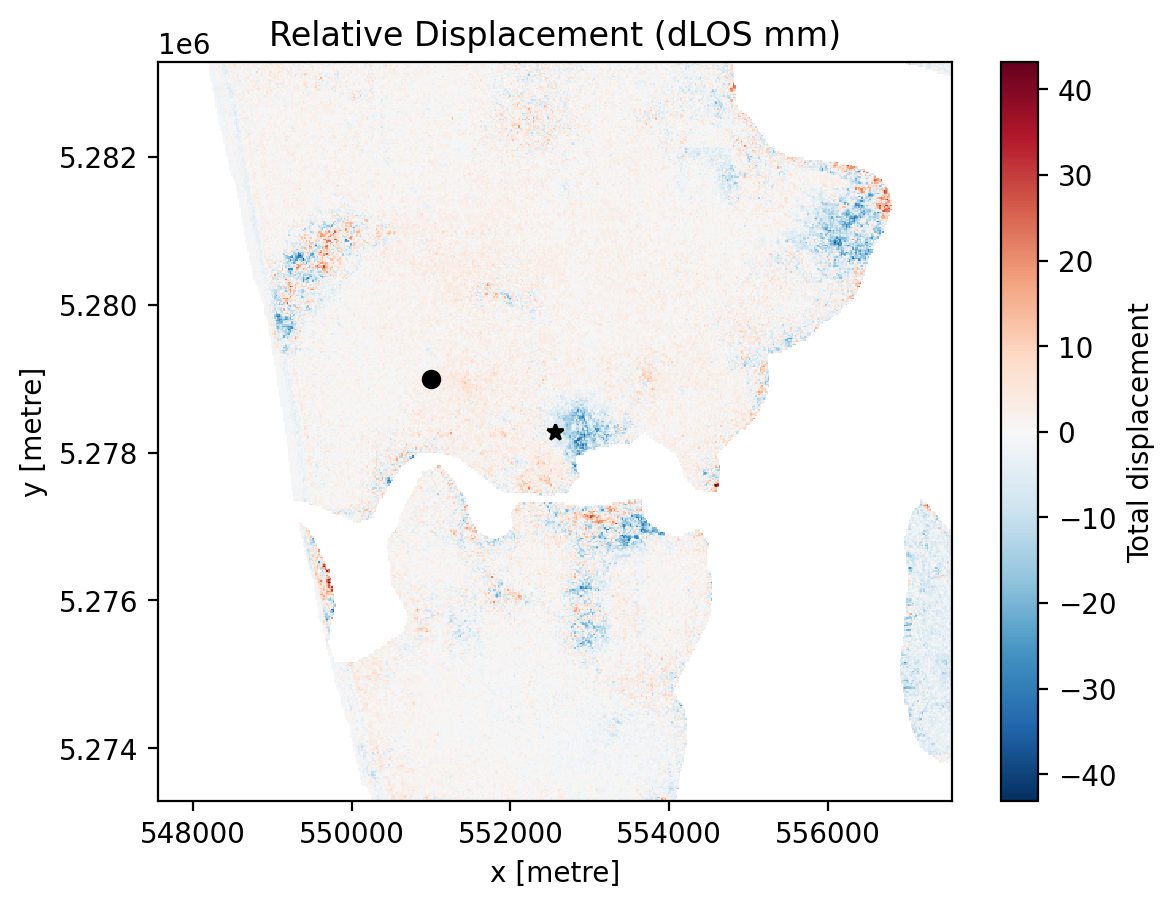

In [21]:
# ideas:
# mask incoherent areas (parks?)
# NOTE: better to use polygon to get range of displacements
d.name = 'Total displacement'
d.plot.imshow()
plt.title('Relative Displacement (dLOS mm)')
plt.plot(xref, yref,'ko', label='reference');
plt.plot(xcen,ycen,'k*')
#plt.title(str(daN.isel(time=i).stac_id.values));

## Timeseries

Warning: this is currently a bit messy and not cross-validated with other time-series algorithms!

In [22]:
items[0].id

'064_135602_IW1_20190123_20190111_5rlks'

In [23]:
# should match order of items
gf = gpd.read_file('items-A64.json')
gf.head(3)

,id,start_datetime,end_datetime,processingDate,burstId,granules,proj:epsg,proj:geometry,proj:projjson,datetime,geometry
0,064_135602_IW1_20190123_20190111_5rlks,2019-01-23 01:53:26+00:00,2019-01-11 01:53:26+00:00,2023-12-09 05:09:19+00:00,064_135602_IW,"[S1_135602_IW1_20190123T015326_VV_C915-BURST, ...",32610,"{'type': 'Polygon', 'coordinates': [[[540340.0...",{'$schema': 'https://proj.org/schemas/v0.5/pro...,2019-01-23 01:53:26+00:00,"POLYGON ((-122.46345 47.57445, -120.99688 47.5..."
1,064_135602_IW1_20190312_20190123_5rlks,2019-03-12 01:53:25+00:00,2019-01-23 01:53:26+00:00,2023-12-09 05:09:19+00:00,064_135602_IW,"[S1_135602_IW1_20190312T015325_VV_B3ED-BURST, ...",32610,"{'type': 'Polygon', 'coordinates': [[[540420.0...",{'$schema': 'https://proj.org/schemas/v0.5/pro...,2019-03-12 01:53:25+00:00,"POLYGON ((-122.46238 47.57443, -120.99581 47.5..."
2,064_135602_IW1_20190324_20190312_5rlks,2019-03-24 01:53:25+00:00,2019-03-12 01:53:25+00:00,2023-12-09 05:09:19+00:00,064_135602_IW,"[S1_135602_IW1_20190324T015325_VV_F4C4-BURST, ...",32610,"{'type': 'Polygon', 'coordinates': [[[540400.0...",{'$schema': 'https://proj.org/schemas/v0.5/pro...,2019-03-24 01:53:25+00:00,"POLYGON ((-122.46265 47.57449, -121.01008 47.5..."


In [24]:
# Calculate timeseries on subset
m_ints, n_rows, n_cols = da.shape

In [25]:
dates = pd.unique(gf[['start_datetime', 'end_datetime']].values.ravel())
dates.sort()
n_dates = len(dates)

In [26]:
G = np.zeros((m_ints,n_dates)) #i,j row,col indexing

In [27]:
sD = pd.Series(np.arange(n_dates), dates) #Date lookup table
sD

2019-01-11 01:53:26+00:00      0
2019-01-23 01:53:26+00:00      1
2019-03-12 01:53:25+00:00      2
2019-03-24 01:53:25+00:00      3
2019-04-05 01:53:26+00:00      4
                            ... 
2023-10-11 01:54:39+00:00    134
2023-10-23 01:54:40+00:00    135
2023-11-04 01:54:39+00:00    136
2023-11-16 01:54:39+00:00    137
2023-11-28 01:54:39+00:00    138
Length: 139, dtype: int64

In [28]:
sD.index

DatetimeIndex(['2019-01-11 01:53:26+00:00', '2019-01-23 01:53:26+00:00',
               '2019-03-12 01:53:25+00:00', '2019-03-24 01:53:25+00:00',
               '2019-04-05 01:53:26+00:00', '2019-04-17 01:53:26+00:00',
               '2019-04-29 01:53:27+00:00', '2019-05-11 01:53:27+00:00',
               '2019-05-23 01:53:28+00:00', '2019-06-16 01:53:29+00:00',
               ...
               '2023-08-12 01:54:37+00:00', '2023-08-24 01:54:38+00:00',
               '2023-09-05 01:54:39+00:00', '2023-09-17 01:54:40+00:00',
               '2023-09-29 01:54:40+00:00', '2023-10-11 01:54:39+00:00',
               '2023-10-23 01:54:40+00:00', '2023-11-04 01:54:39+00:00',
               '2023-11-16 01:54:39+00:00', '2023-11-28 01:54:39+00:00'],
              dtype='datetime64[ns, UTC]', length=139, freq=None)

In [29]:
for i,row in gf.iterrows():
    j = sD[row.start_datetime]
    k = sD[row.end_datetime]
    G[i,j] = 1 
    G[i,k] = -1

In [30]:
# Get numpy data cube (stack of interferograms)

stack = da.values
print(stack.shape)
d_flat = stack.reshape(stack.shape[0], -1)
print(d_flat.shape)

(142, 500, 500)
(142, 250000)


In [31]:
# Run Inversion w/ augmented matrix to fix first date to zero
# Since it's a subset load everything into memory. think about ways to do this more efficiently for entire array...

G = np.matrix(G)
d = np.matrix(d_flat)
n_pix = d.shape[-1]

F = np.matrix(np.zeros(n_dates))
F[0,0] = 1
h = np.matrix(np.zeros(n_pix)) #fixes initial position to zero...

Gaug = np.r_[np.c_[G.T*G, F.T], np.c_[F, np.matrix(0)]]
daug = np.r_[G.T*d, h]

maug = Gaug.I *daug
m_est = maug[:-1]

d_est = G*m_est

In [32]:
# Cumulative deformation at each date
m_ts = np.array(m_est)
m_ts = m_ts.reshape(n_dates, n_rows, n_cols)

# Reconstructed interferograms
d_ts = np.array(d_est)
d_ts = d_ts.reshape(m_ints, n_rows, n_cols)

In [33]:
coords = {}
coords['time'] = dates 
coords['x'] = da.x.values
coords['y'] = da.y.values


data = {'displacement': (['time','y','x'], m_ts) }

dsTS = xr.Dataset(data, coords)

In [34]:
time_series = dsTS.sel(x=xcen, y=ycen, method='nearest') 

Text(0, 0.5, 'dLOS (cm)')

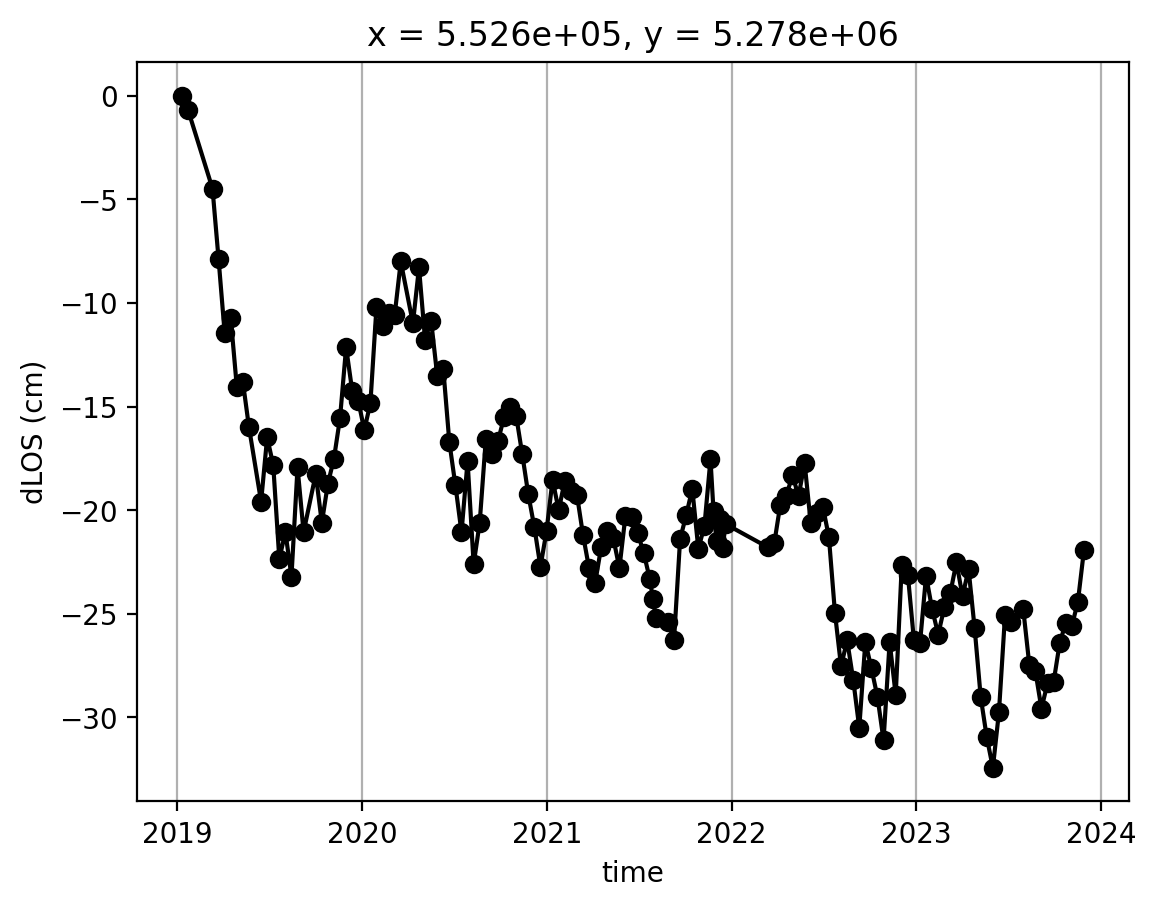

In [35]:
time_series.displacement.plot(color='k', marker='o');
plt.grid(axis='x')
plt.ylabel('dLOS (cm)')

#### TODO

- clean up code
- xarray polyfit
- compare with mintpy solution